# Simulate inference data

Power analysis for DM, DV, and DC

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import statsmodels.api as sm
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', 100)
import pickle as pkl
import time
import string
from sklearn.datasets import make_spd_matrix
from statsmodels.stats.moment_helpers import cov2corr
import string

/tmp/ipykernel_1273541/644427709.py:12: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.10.egg')
import memento
import memento.simulate as simulate

In [15]:
data_path = '/data_volume/memento/simulation/'

### Generate simulated simple DE dataset

In [5]:
ifn_adata = sc.read('/data_volume/memento/hbec/' + 'HBEC_type_I_filtered_counts_deep.h5ad')
q=0.07

In [6]:
adata_1 = ifn_adata[(ifn_adata.obs['cell_type'] == 'ciliated') & (ifn_adata.obs['stim'] == 'control')]
adata_2 = ifn_adata[(ifn_adata.obs['cell_type'] == 'ciliated') & (ifn_adata.obs['stim'] == 'beta')]

x_param_1, z_param_1, Nc_1, good_idx_1 = simulate.extract_parameters(adata_1.X, q=q)
x_param_2, z_param_2, Nc_2, good_idx_2 = simulate.extract_parameters(adata_2.X, q=q)

In [7]:
common_set = np.array(list(set(good_idx_1) & set(good_idx_2)))
z_param_1 = (
    np.array([x for x,i in zip(z_param_1[0], good_idx_1) if i in common_set]),
    np.array([x for x,i in zip(z_param_1[1], good_idx_1) if i in common_set]))
z_param_2 = (
    np.array([x for x,i in zip(z_param_2[0], good_idx_2) if i in common_set]),
    np.array([x for x,i in zip(z_param_2[1], good_idx_2) if i in common_set]))

# z_param_1 = (np.concatenate([z_param_1[0], z_param_1[0]]), np.concatenate([z_param_1[1], z_param_1[1]]))
# z_param_2 = (np.concatenate([z_param_2[0], z_param_2[0]]), np.concatenate([z_param_2[1], z_param_2[1]]))

In [8]:
pos_var_condition = (z_param_1[1] > 0) & (z_param_2[1] > 0)
z_param_1 = (z_param_1[0][pos_var_condition], z_param_1[1][pos_var_condition])
z_param_2 = (z_param_2[0][pos_var_condition], z_param_2[1][pos_var_condition])

In [9]:
num_groups_per_condition = 4
num_cells_list = stats.poisson.rvs(mu=200, size=num_groups_per_condition)
num_total_cells = num_cells_list.sum()
num_genes = z_param_1[0].shape[0]

In [10]:
groups = list(string.ascii_lowercase[:num_groups_per_condition])
conditions = ['ctrl', 'stim']
design = pd.DataFrame()
design['group'] = np.random.choice(groups, num_total_cells)
design['condition'] = np.random.choice(conditions, num_total_cells)
dmatrix = pd.concat([
    pd.get_dummies(design[['group']]).astype(float),
    pd.get_dummies(design[['group']]).astype(float) * (design[['condition']]=='stim').astype(int).values,
    (design[['condition']]=='stim').astype(int)], axis=1).values

In [11]:
def convert_params_nb(mu, theta):
	"""
	Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

	See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
	"""
	r = theta
	var = mu + 1 / r * mu ** 2
	p = (var - mu) / var
	return r, 1 - p

In [ ]:
# trial = 0
# mean_donor_effects =  stats.norm.rvs(scale=1, size=(num_groups_per_condition, num_genes))
# disp_donor_effects = stats.norm.rvs(scale=1, size=(num_groups_per_condition, num_genes))

# # Get global mean first, then deviations
# mean_condition_effects = stats.norm.rvs(scale=1, size=num_genes)
# null_de_genes = np.ones(num_genes)
# null_de_genes[np.random.choice(num_genes, int(num_genes*0.8))]=1
# mean_condition_effects[null_de_genes.astype(bool)] = 0

# disp_condition_effects = stats.norm.rvs(scale=1, size=num_genes)
# disp_condition_effects[np.random.choice(num_genes, int(num_genes*0.8))] = 0

# mean_interaction_effects =  stats.norm.rvs(scale=1, size=(num_groups_per_condition, num_genes))
# disp_interaction_effects = stats.norm.rvs(scale=0, size=(num_groups_per_condition, num_genes))

# mean_effects = np.vstack([mean_donor_effects, mean_interaction_effects, mean_condition_effects])
# disp_effects = np.vstack([disp_donor_effects, mean_interaction_effects, disp_condition_effects])


# means = np.exp(dmatrix@mean_effects)
# dispersions = np.exp(dmatrix@disp_effects)

# counts = stats.nbinom.rvs(*convert_params_nb(means, 1/dispersions))
# _, hyper_captured = simulate.capture_sampling(counts, q=q, process='hyper')

# expr_df = pd.DataFrame(hyper_captured)
# grouped = pd.concat([design, expr_df], axis=1)
# pseudobulks = grouped.groupby(['group', 'condition']).sum()
# pseudobulks.index = [x+'-'+y for x, y in itertools.product(groups, conditions)]

# anndata = sc.AnnData(sp.sparse.csr_matrix(hyper_captured))
# anndata.var['is_null'] = null_de_genes
# anndata.obs = design.copy()

# anndata.write(data_path + 'means/anndata_{}.h5ad'.format(trial))
# pseudobulks.T.to_csv(data_path + 'means/pseudobulks_{}.csv'.format(trial))

# norm_adata = anndata.copy().copy()
# sc.pp.normalize_total(norm_adata, target_sum=1)
# norm_adata.write(data_path + 'means/norm_anndata_{}.h5ad'.format(trial))

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
num_groups_per_condition = 4
num_cells_list = stats.poisson.rvs(mu=150, size=num_groups_per_condition*2)
num_genes = z_param_1[0].shape[0]

treatment_effect = (np.log(z_param_2[0]) - np.log(z_param_1[0]))
null_genes = stats.bernoulli.rvs(p=0.9, size=treatment_effect.shape[0]).astype(bool)#null_genes = (np.absolute(treatment_effect) < 0.1)
treatment_effect[null_genes] = 0

#make noisy treatment effect
treatment_effect = stats.norm.rvs(treatment_effect, scale=0.3, size=(num_groups_per_condition, treatment_effect.shape[0]))

dispersions = (z_param_1[1] - z_param_1[0])/z_param_1[0]**2
dispersions_2 = (z_param_2[1] - z_param_2[0])/z_param_2[0]**2
dispersions[dispersions < 0] = 0.001
dispersions_2[dispersions_2 < 0] = 0.001

# dispersions = 0.1
dispersions_2 = dispersions_2+1

# Replicates
random_intercepts = stats.norm.rvs(scale=0.5, size=(num_groups_per_condition, num_genes))
random_dispersion_modifiers = stats.norm.rvs(loc=0, scale=0.2,  size=(num_groups_per_condition, 1))
# random_intercepts = np.vstack([random_intercepts, random_intercepts])

means_1 = np.exp(np.log(z_param_1[0]) + random_intercepts[:num_groups_per_condition])
means_2 = np.exp(np.log(z_param_1[0])+treatment_effect+ random_intercepts[:num_groups_per_condition])#means_1.copy()
# np.random.shuffle(means_2[:1000]) # create differences in means while keeping overall mean identical

variances_1 = means_1 + (dispersions +random_dispersion_modifiers) *means_1**2
variances_2 = means_2 + (dispersions_2 +random_dispersion_modifiers)*means_2**2

means = np.vstack([means_1, means_2])
variances = np.vstack([variances_1, variances_2])

In [13]:
# simulation_parameters = pd.DataFrame(np.vstack([means, variances, null_genes, treatment_effect])).T
# simulation_parameters.columns = ['mean_'+str(i) for i in range(num_groups_per_condition*2)] + ['var_'+str(i) for i in range(num_groups_per_condition*2)] + ['null', 'treatment_effect']
# simulation_parameters.to_csv(data_path + 'means/parameters.csv', index=False)

In [17]:
for trial in range(1):

    anndata_list = []
    true_anndata_list = []
    pseudobulks = []
    rep_pseudobulks = []
    groups = string.ascii_lowercase[:num_groups_per_condition]+string.ascii_lowercase[:num_groups_per_condition]
    idx = 0
    for m, v, g, num_cells in zip(means, variances, groups, num_cells_list):

        true_data = simulate.simulate_transcriptomes(
            n_cells=num_cells, 
            means=m,
            variances=v,
            Nc=Nc_1,
            norm_cov='indep')
        true_data[(true_data < 0) | (true_data > 1000)] = 0

        _, hyper_captured = simulate.capture_sampling(true_data, q=q, process='hyper')

        pseudobulks.append(hyper_captured.sum(axis=0))
        rep_pseudobulks.append(hyper_captured[:int(num_cells/2)].sum(axis=0))
        rep_pseudobulks.append(hyper_captured[int(num_cells/2):].sum(axis=0))

        print(true_data.sum())
        anndata = sc.AnnData(sp.sparse.csr_matrix(hyper_captured))
        anndata.obs['group'] = g
        anndata.obs['condition'] = 'ctrl' if idx < num_groups_per_condition else 'stim'
        
        true_anndata = sc.AnnData(sp.sparse.csr_matrix(true_data))
        true_anndata.obs['group'] = g
        true_anndata.obs['condition'] = 'ctrl' if idx < num_groups_per_condition else 'stim'

        anndata_list.append(anndata)
        true_anndata_list.append(true_anndata)
        idx += 1

    simulated_adata = sc.AnnData.concatenate(*anndata_list)
    simulated_adata.var['is_de'] = null_genes
    

    
    pseudobulks = pd.DataFrame(np.vstack(pseudobulks)).T
    pseudobulks.index.name = 'Symbols'
    rep_pseudobulks = pd.DataFrame(np.vstack(rep_pseudobulks)).T
    rep_pseudobulks.index.name = 'Symbols'

    simulated_adata.write(data_path + 'de/anndata.h5ad'.format(trial))
    pseudobulks.to_csv(data_path + 'de/pseudobulks.csv'.format(trial))

    norm_adata = simulated_adata.copy().copy()
    sc.pp.normalize_total(norm_adata, target_sum=1)
#     sc.pp.log1p(norm_adata)
#     sc.pp.scale(norm_adata)
    norm_adata.write(data_path + 'de/norm_anndata.h5ad'.format(trial))

26928895
25196458
27080049
25833810
24172773
27539236
27308747
22664892


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.10/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [20]:
pseudobulks.isnull().sum()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64

In [52]:
# Get relative data
true_cell_sizes = true_data.sum(axis=1)
# true_cell_sizes = true_cell_sizes/true_cell_sizes.mean()
captured_cell_sizes = hyper_captured.sum(axis=1)
# captured_cell_sizes = captured_cell_sizes/captured_cell_sizes.mean()

relative_true_data = true_data/true_cell_sizes.reshape(-1,1)
relative_captured_data = hyper_captured/captured_cell_sizes.reshape(-1,1)

expr_genes = (hyper_captured.mean(axis=0) > 0.05)# & (stats.uniform.rvs(size=hyper_captured.shape[1]) < 0.05)
hyper_captured = hyper_captured[:, expr_genes]
relative_true_data = relative_true_data[:, expr_genes]
relative_captured_data = relative_captured_data[:, expr_genes]

In [545]:
# Compute the mean
relative_true_mean = relative_true_data.mean(axis=0)
relative_captured_mean = relative_captured_data.mean(axis=0)

# Compute the variance
relative_true_var = relative_true_data.var(axis=0)

Text(0, 0.5, 'relative true mean')

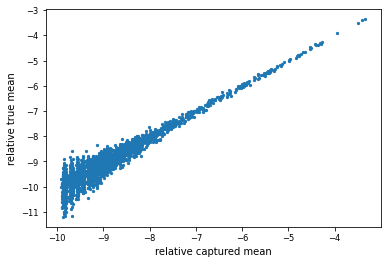

In [546]:
plt.scatter(np.log(relative_captured_mean), np.log(relative_true_mean), s=5)
plt.xlabel('relative captured mean'); plt.ylabel('relative true mean')

In [547]:
theoretical_se = np.sqrt(relative_true_data.var(axis=0)/num_cells)

m_hat = relative_captured_data.mean(axis=0)
naive_var_hat = relative_captured_data.var(axis=0)
memento_var_hat = naive_var_hat-(1-q)*(hyper_captured/(captured_cell_sizes**2-captured_cell_sizes*(1-q)).reshape(-1,1)).mean(axis=0)

naive_se = np.sqrt(naive_var_hat/num_cells)
memento_se = np.sqrt(memento_var_hat/num_cells)
memento_theoretical_log_mean_se = (np.log(relative_captured_mean + memento_se) - np.log(relative_captured_mean - memento_se))/2

/tmp/ipykernel_3540/988341163.py:8: RuntimeWarning: invalid value encountered in sqrt
  memento_se = np.sqrt(memento_var_hat/num_cells)


/tmp/ipykernel_3540/3398842061.py:1: RuntimeWarning: invalid value encountered in log
  plt.scatter(np.log(relative_true_var), np.log(memento_var_hat), s=1)


Text(0, 0.5, 'memento variance (from sampled data)')

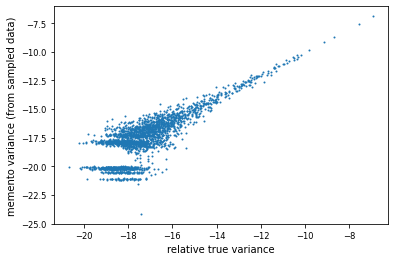

In [548]:
plt.scatter(np.log(relative_true_var), np.log(memento_var_hat), s=1)
plt.xlabel('relative true variance'); plt.ylabel('memento variance (from sampled data)')

In [164]:
true_b_means = []
captured_b_means = []
true_b_log_means = []
captured_b_log_means = []
true_b_vars = []
captured_b_naive_vars = []
captured_b_memento_vars = []

for b in range(1000):
    random_idx = np.random.choice(num_cells, num_cells, replace=True)
    
    true_b_means.append(relative_true_data[random_idx].mean(axis=0))
    true_b_log_means.append(np.log(true_b_means[-1]))
    true_b_vars.append(relative_true_data[random_idx].var(axis=0))
    
    captured_b_means.append(relative_captured_data[random_idx].mean(axis=0))
    captured_b_log_means.append(np.log(captured_b_means[-1]))
    
    captured_b_naive_vars.append(relative_captured_data[random_idx].var(axis=0))
    captured_b_memento_vars.append(captured_b_naive_vars[-1]-(1-q)*(hyper_captured/(captured_cell_sizes**2-captured_cell_sizes*(1-q)).reshape(-1,1)).mean(axis=0))

true_b_means = np.vstack(true_b_means)
captured_b_means = np.vstack(captured_b_means)
true_b_log_means = np.vstack(true_b_log_means)
captured_b_log_means = np.vstack(captured_b_log_means)
true_b_vars = np.vstack(true_b_vars)
captured_b_naive_vars = np.vstack(captured_b_naive_vars)
captured_b_memento_vars = np.vstack(captured_b_memento_vars)

In [165]:
true_b_se = np.vstack(true_b_means).std(axis=0)
captured_b_se = np.vstack(captured_b_means).std(axis=0)

true_b_log_mean_se = np.vstack(true_b_log_means).std(axis=0)
captured_b_log_mean_se = np.vstack(captured_b_log_means).std(axis=0)

true_b_var_se = np.vstack(true_b_vars).std(axis=0)


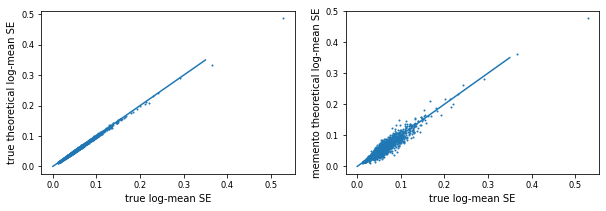

In [166]:
true_theoretical_log_mean_se =  (np.log(relative_true_mean + theoretical_se) - np.log(relative_true_mean - theoretical_se))/2
memento_theoretical_log_mean_se = (np.log(relative_captured_mean + memento_se) - np.log(relative_captured_mean - memento_se))/2

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.scatter(true_b_log_mean_se, true_theoretical_log_mean_se, s=1)
plt.xlabel('true log-mean SE'); plt.ylabel('true theoretical log-mean SE')
plt.plot([0, 0.35], [0, 0.35])

plt.subplot(1, 2, 2)
plt.scatter(true_b_log_mean_se, memento_theoretical_log_mean_se, s=1)
plt.xlabel('true log-mean SE'); plt.ylabel('memento theoretical log-mean SE')
plt.plot([0, 0.35], [0, 0.35])

In [167]:
from statsmodels.nonparametric.kernel_regression import KernelReg as kr
curve = kr(np.log(memento_var_hat), np.log(m_hat), var_type='c')
mean_log_var = curve.fit(np.log(m_hat))


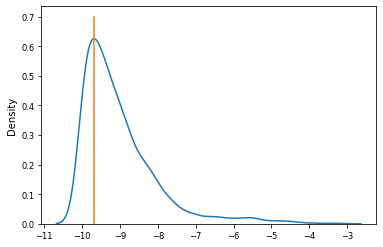

In [168]:
kde = stats.gaussian_kde(np.log(m_hat))
grid = np.linspace(np.log(m_hat).min(), np.log(m_hat).max(), 1000)
maximizer = grid[np.argmax(kde(grid))]
sns.kdeplot(np.log(m_hat))
plt.plot([maximizer, maximizer], [0, 0.7])
s = 0.1
m_hat_s = (1-s)*m_hat + s*np.exp(maximizer)

<AxesSubplot:ylabel='Density'>

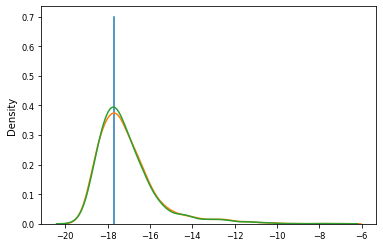

In [169]:
kde = stats.gaussian_kde(np.log(memento_var_hat))
grid = np.linspace(np.log(memento_var_hat).min(), np.log(memento_var_hat).max(), 1000)
maximizer = grid[np.argmax(kde(grid))]
plt.plot([maximizer, maximizer], [0, 0.7])
s = 0.1

sns.kdeplot(np.log(relative_true_var))
memento_var_hat_s = (1-s)*memento_var_hat + s*np.exp(maximizer)
sns.kdeplot(np.log(memento_var_hat_s))

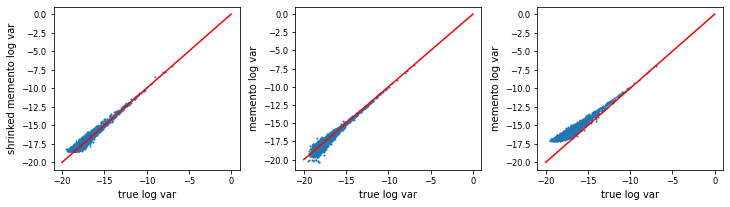

In [170]:
s = 0.5
memento_var_tilde = np.exp( np.maximum(np.log(memento_var_hat),mean_log_var[0]) )
# memento_var_tilde = np.exp( (1-s)*np.log(memento_var_hat)+s*mean_log_var[0]) 

plt.figure(figsize=(12,3))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1, 3, 1)
plt.scatter(np.log(relative_true_var), np.log(memento_var_tilde), s=1)
plt.xlabel('true log var'); plt.ylabel('shrinked memento log var')
plt.plot([-20, 0], [-20, 0], color='r')

plt.subplot(1, 3, 2)
plt.scatter(np.log(relative_true_var), np.log(memento_var_hat), s=1)
plt.xlabel('true log var'); plt.ylabel('memento log var')
plt.plot([-20, 0], [-20, 0], color='r')

plt.subplot(1, 3, 3)
plt.scatter(np.log(relative_true_var), np.log(naive_var_hat), s=1)
plt.xlabel('true log var'); plt.ylabel('memento log var')
plt.plot([-20, 0], [-20, 0], color='r')

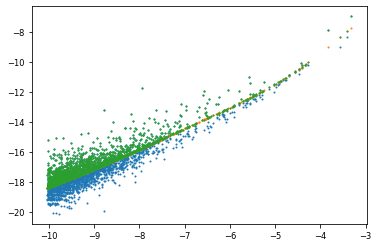

In [145]:
plt.scatter(np.log(m_hat), np.log(memento_var_hat), s=1)
plt.scatter(np.log(m_hat), mean_log_var[0], s=1)
plt.scatter(np.log(m_hat), np.log(memento_var_tilde), s=1)


(-2.5, 2.5)

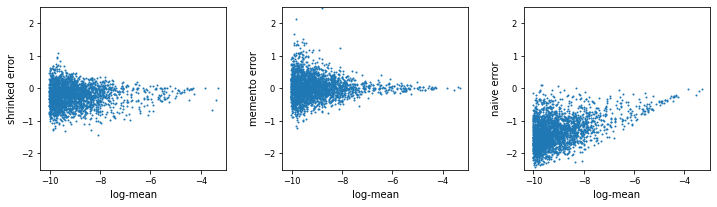

In [144]:
plt.figure(figsize=(12,3))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1, 3, 1)
plt.scatter(np.log(m_hat), np.log(relative_true_var)-np.log(memento_var_tilde), s=1)
plt.xlabel('log-mean'); plt.ylabel('shrinked error')
plt.ylim(-2.5, 2.5)

plt.subplot(1, 3, 2)
plt.scatter(np.log(m_hat), np.log(relative_true_var)-np.log(memento_var_hat), s=1)
plt.xlabel('log-mean'); plt.ylabel('memento error')
plt.ylim(-2.5, 2.5)

plt.subplot(1, 3, 3)
plt.scatter(np.log(m_hat), np.log(relative_true_var)-np.log(naive_var_hat), s=1)
plt.xlabel('log-mean'); plt.ylabel('naive error')
plt.ylim(-2.5, 2.5)


In [41]:
memento_var_tilde

array([4.70025784e-09, 6.39951249e-07, 3.42291282e-08, ...,
       6.65972617e-09, 1.53737941e-08, 8.80458949e-08])

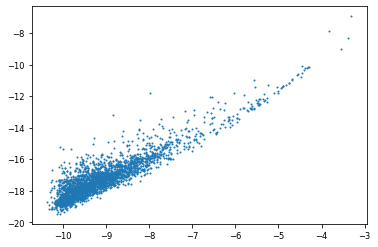

In [31]:
plt.scatter(np.log(relative_true_mean), np.log(relative_true_var), s=1)

In [101]:
se_error = true_theoretical_log_mean_se - memento_theoretical_log_mean_se


In [133]:
curve = kr(memento_theoretical_log_mean_se, np.log(relative_captured_mean), var_type='c')
curve_fit = curve.fit(np.log(relative_captured_mean))

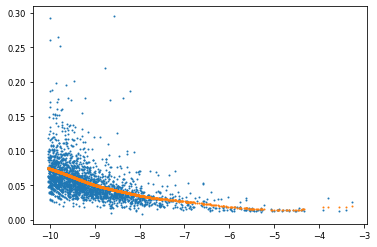

In [139]:
plt.scatter(np.log(relative_captured_mean), memento_theoretical_log_mean_se, s=1)
plt.scatter(np.log(relative_captured_mean), curve_fit[0], s=1)
# shrinked_se = 

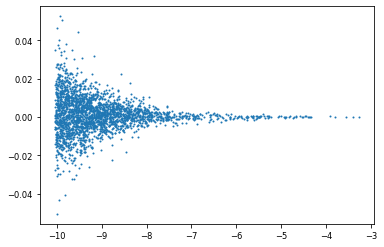

In [111]:
plt.scatter(np.log(relative_captured_mean), se_error, s=1)

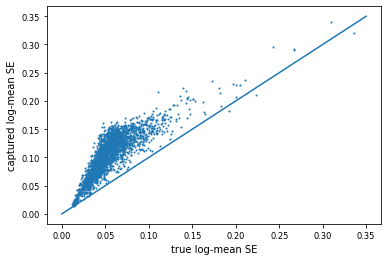

In [99]:
plt.scatter(true_b_log_mean_se, captured_b_log_mean_se, s=1)
plt.xlabel('true log-mean SE'); plt.ylabel('captured log-mean SE')
plt.plot([0, 0.35], [0, 0.35])

In [ ]:
plt.scatter(true_b_log_mean_se, captured_b_log_mean_se, s=1)
plt.xlabel('true log-mean SE'); plt.ylabel('captured log-mean SE')
plt.plot([0, 0.35], [0, 0.35])

In [125]:
np.median(np.vstack(true_b_means)[:,0])

5.325431098375511e-06

In [126]:
np.median(np.log(np.vstack(true_b_means)[:,0]))

-12.143016912406374

In [127]:
np.log(np.median(np.vstack(true_b_means)[:,0]))

-12.143016892204253

<AxesSubplot:ylabel='Density'>

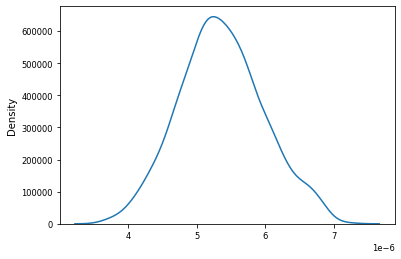

In [128]:
sns.kdeplot(np.vstack(true_b_means)[:,0])
# sns.kdeplot(np.vstack(captured_b_means)[:,0])

In [146]:
np.log10(np.vstack(captured_b_naive_vars)[:,gene_idx]).var()

0.0007436143487606862

In [147]:
np.log10(np.vstack(captured_b_memento_vars)[:,gene_idx]).var()

0.024631461131295634

In [ ]:
gene_idx = 30
sns.kdeplot(np.vstack(true_b_vars)[:,gene_idx])
sns.kdeplot(np.vstack(captured_b_naive_vars)[:,gene_idx])
sns.kdeplot(np.vstack(captured_b_memento_vars)[:,gene_idx])

<AxesSubplot:ylabel='Density'>

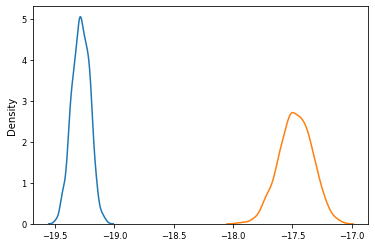

In [168]:
gene_idx = 200
sns.kdeplot(np.log(np.vstack(true_b_vars)[:,gene_idx]))
sns.kdeplot(np.log(np.vstack(captured_b_naive_vars)[:,gene_idx]))
# sns.kdeplot(np.log(np.vstack(captured_b_memento_vars)[:,gene_idx]))

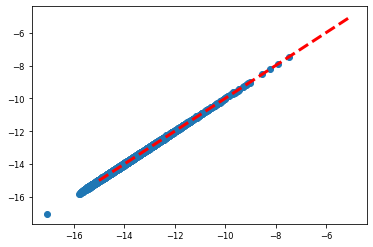

In [42]:
plt.scatter(np.log(theoretical_se),np.log(true_b_se))
plt.plot([-15, -5], [-15, -5], color='r', lw=3, ls='--')

/tmp/ipykernel_3592/560846930.py:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(naive_se),np.log(captured_b_se))


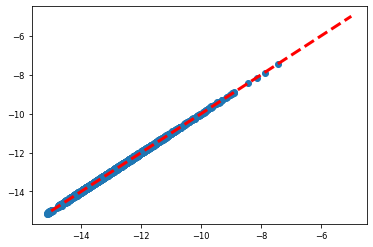

In [43]:
plt.scatter(np.log(naive_se),np.log(captured_b_se))
plt.plot([-15, -5], [-15, -5], color='r', lw=3, ls='--')

/tmp/ipykernel_3592/566096707.py:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(theoretical_se),np.log(captured_b_se))


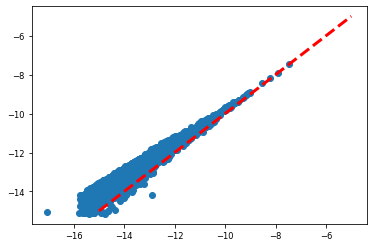

In [44]:
plt.scatter(np.log(theoretical_se),np.log(captured_b_se))
plt.plot([-15, -5], [-15, -5], color='r', lw=3, ls='--')

/tmp/ipykernel_3592/3659162367.py:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(theoretical_se),np.log(naive_se), s=1)


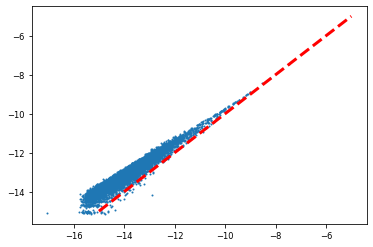

In [170]:
plt.scatter(np.log(theoretical_se),np.log(naive_se), s=1)
plt.plot([-15, -5], [-15, -5], color='r', lw=3, ls='--')

In [171]:
theoretical_se

array([6.42841730e-07, 2.25092460e-06, 1.05229451e-06, ...,
       1.12310345e-06, 4.30457520e-06, 4.83316718e-06])

/tmp/ipykernel_3592/4200842059.py:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(m_hat),np.log(memento_se), s=1)


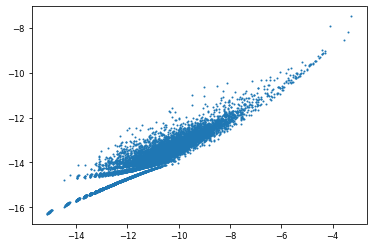

In [172]:
plt.scatter(np.log(m_hat),np.log(memento_se), s=1)


In [194]:
np.log(captured_b_se)-np.log(memento_se)

/tmp/ipykernel_3592/3136963127.py:1: RuntimeWarning: divide by zero encountered in log
  np.log(captured_b_se)-np.log(memento_se)
/tmp/ipykernel_3592/3136963127.py:1: RuntimeWarning: invalid value encountered in subtract
  np.log(captured_b_se)-np.log(memento_se)


array([0.48726646, 0.82469796, 0.76487828, ..., 0.89534474, 0.27158305,
       0.60538325])

/tmp/ipykernel_3592/4235304642.py:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(captured_b_se),np.log(memento_se), s=1)


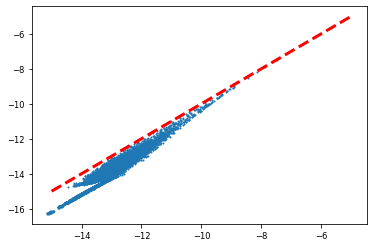

In [193]:
plt.scatter(np.log(captured_b_se),np.log(memento_se), s=1)
plt.plot([-15, -5], [-15, -5], color='r', lw=3, ls='--')

/tmp/ipykernel_3592/2442040919.py:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(theoretical_se),np.log(memento_se), s=1)


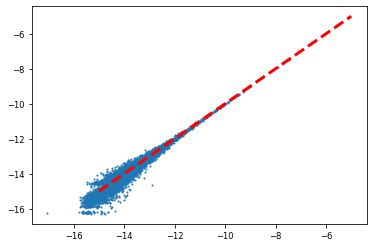

In [173]:
plt.scatter(np.log(theoretical_se),np.log(memento_se), s=1)
plt.plot([-15, -5], [-15, -5], color='r', lw=3, ls='--')

### Generate simulated repeated DE dataset

In [18]:
ifn_adata = sc.read('/data_volume/memento/demux/' + 'interferon_filtered.h5ad')
q=0.1

In [19]:
adata_1 = ifn_adata[(ifn_adata.obs['cell'] == 'CD4 T cells') & (ifn_adata.obs['stim'] == 'ctrl')]
adata_2 = ifn_adata[(ifn_adata.obs['cell'] == 'CD4 T cells') & (ifn_adata.obs['stim'] == 'stim')]

x_param_1, z_param_1, Nc_1, good_idx_1 = simulate.extract_parameters(adata_1.X, q=q)
x_param_2, z_param_2, Nc_2, good_idx_2 = simulate.extract_parameters(adata_2.X, q=q)

In [20]:
common_set = np.array(list(set(good_idx_1) & set(good_idx_2)))
z_param_1 = (
    np.array([x for x,i in zip(z_param_1[0], good_idx_1) if i in common_set]),
    np.array([x for x,i in zip(z_param_1[1], good_idx_1) if i in common_set]))
z_param_2 = (
    np.array([x for x,i in zip(z_param_2[0], good_idx_2) if i in common_set]),
    np.array([x for x,i in zip(z_param_2[1], good_idx_2) if i in common_set]))

# z_param_1 = (np.concatenate([z_param_1[0], z_param_1[0]]), np.concatenate([z_param_1[1], z_param_1[1]]))
# z_param_2 = (np.concatenate([z_param_2[0], z_param_2[0]]), np.concatenate([z_param_2[1], z_param_2[1]]))

In [21]:
num_groups_per_condition = 2
num_cells = 100
num_genes = z_param_1[0].shape[0]

treatment_effect = stats.uniform.rvs(0, 0.5, size=num_genes)#np.log(z_param_2[0]) - np.log(z_param_1[0])
null_genes = stats.bernoulli.rvs(p=0.9, size=treatment_effect.shape[0]).astype(bool)#null_genes = (np.absolute(treatment_effect) < 0.1)
treatment_effect[null_genes] = 0

dispersions = (z_param_1[1] - z_param_1[0])/z_param_1[0]**2
dispersions_2 = (z_param_2[1] - z_param_2[0])/z_param_2[0]**2
dispersions[dispersions < 0] = 0.001
dispersions_2[dispersions_2 < 0] = 0.001

# Replicates
random_intercepts = stats.norm.rvs(scale=0.1, size=(num_groups_per_condition*2, num_genes))
# random_intercepts = np.vstack([random_intercepts, random_intercepts])

means_1 = np.exp(np.log(z_param_1[0]) + random_intercepts[:num_groups_per_condition])
means_2 = np.exp(np.log(z_param_1[0]) + treatment_effect + random_intercepts[num_groups_per_condition:])

variances_1 = means_1 + dispersions*means_1**2
variances_2 = means_2 + (dispersions_2)*means_2**2

means = np.vstack([means_1, means_2])
variances = np.vstack([variances_1, variances_2])

In [22]:
simulation_parameters = pd.DataFrame(np.vstack([means, variances, null_genes, treatment_effect])).T
simulation_parameters.columns = ['mean_'+str(i) for i in range(num_groups_per_condition*2)] + ['var_'+str(i) for i in range(num_groups_per_condition*2)] + ['null', 'treatment_effect']
simulation_parameters.to_csv(data_path + 'means/repeated/parameters.csv', index=False)

In [23]:
for trial in range(1):

    anndata_list = []
    pseudobulks = []
    rep_pseudobulks = []
    groups = string.ascii_lowercase[:num_groups_per_condition*2]
    idx = 0
    for m, v, g in zip(means, variances, groups):

        true_data = simulate.simulate_transcriptomes(
            n_cells=num_cells, 
            means=m,
            variances=v,
            Nc=Nc_1,
            norm_cov='indep')
        true_data[(true_data < 0) | (true_data > 1000)] = 0

        _, hyper_captured = simulate.capture_sampling(true_data, q=q, process='hyper')

        pseudobulks.append(hyper_captured.sum(axis=0))
        rep_pseudobulks.append(hyper_captured[:int(num_cells/2)].sum(axis=0))
        rep_pseudobulks.append(hyper_captured[int(num_cells/2):].sum(axis=0))

        print(true_data.sum())
        anndata = sc.AnnData(sp.sparse.csr_matrix(hyper_captured))
        anndata.obs['group'] = g
        anndata.obs['condition'] = 'ctrl' if idx < num_groups_per_condition else 'stim'

        anndata_list.append(anndata)
        idx += 1

    simulated_adata = sc.AnnData.concatenate(*anndata_list)
    simulated_adata.var['is_null'] = null_genes
    simulated_adata.var['treatment_effect'] = treatment_effect
    pseudobulks = pd.DataFrame(np.vstack(pseudobulks)).T
    pseudobulks.index.name = 'Symbols'
    rep_pseudobulks = pd.DataFrame(np.vstack(rep_pseudobulks)).T
    rep_pseudobulks.index.name = 'Symbols'

    simulated_adata.write(data_path + 'means/repeated/anndata_{}.h5ad'.format(trial))
    pseudobulks.to_csv(data_path + 'means/repeated/pseudobulks_{}.csv'.format(trial))
    rep_pseudobulks.to_csv(data_path + 'means/repeated/rep_pseudobulks_{}.csv'.format(trial))

    norm_adata = simulated_adata.copy().copy()
    sc.pp.normalize_total(norm_adata)
    sc.pp.log1p(norm_adata)
    sc.pp.scale(norm_adata)
    norm_adata.write(data_path + 'means/repeated/norm_anndata_{}.h5ad'.format(trial))

1130458


/tmp/ipykernel_10685/4068715106.py:25: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata = sc.AnnData(sp.sparse.csr_matrix(hyper_captured))


1133648


/tmp/ipykernel_10685/4068715106.py:25: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata = sc.AnnData(sp.sparse.csr_matrix(hyper_captured))


1138271


/tmp/ipykernel_10685/4068715106.py:25: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata = sc.AnnData(sp.sparse.csr_matrix(hyper_captured))


1139545


/tmp/ipykernel_10685/4068715106.py:25: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata = sc.AnnData(sp.sparse.csr_matrix(hyper_captured))
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [220]:
ifn_adata = sc.read('/data_volume/memento/demux/' + 'interferon_filtered.h5ad')
inds = ifn_adata.obs.ind.drop_duplicates().tolist()
stims = ['ctrl', 'stim']
cts = ['CD14+ Monocytes',
#  'CD8 T cells',
 'CD4 T cells',
]
num_groups = len(cts)

In [221]:
adata_list = []
q=0.07
for stim in stims:
    for ct in cts:
        print(stim, ct)
        adata_list.append(ifn_adata[(ifn_adata.obs['cell'] == ct) & (ifn_adata.obs['stim'] == stim) ].copy())
        
params = [simulate.extract_parameters(adata.X, q=q) for adata in adata_list]

common_set = set(params[0][3])
for param in params[1:]:
    common_set &= set(param[3])

x_params = [(np.array([x for x,i in zip(param[0][0], param[3]) if i in common_set]),np.array([x for x,i in zip(param[0][1], param[3]) if i in common_set])) for param in params]

log_means = [np.log(x_param[0]) for x_param in x_params]
log_variances = [np.log(x_param[1]) for x_param in x_params]
Ncs = [param[2] for param in params]

regressors = [memento.estimator._fit_mv_regressor(np.exp(lm), np.exp(lv)) for lm, lv in zip(log_means, log_variances)]
rvs = [memento.estimator._residual_variance(np.exp(lm), np.exp(lv), reg) for lm, lv, reg in zip(log_means, log_variances, regressors)]
fs= [np.poly1d(reg) for reg in regressors]

total_average = np.vstack(log_means).mean(axis=0)
group_1_avg = np.vstack(log_means[:num_groups]).mean(axis=0)
group_2_avg = np.vstack(log_means[num_groups:]).mean(axis=0)
group_diff = group_2_avg - group_1_avg
offsets = [group_1_avg - total_average if i < num_groups else group_2_avg - total_average for i in range(num_groups*2)]

null_idxs = np.absolute(group_diff) < 0.1
for offset in offsets:
    offset[~null_idxs] = 0
    
adjusted_log_means = [x-offset for x,offset in zip(log_means, offsets)]
adjusted_log_variances = [f(lm)+np.log(rv) for f, lm, rv in zip(fs, adjusted_log_means, rvs)]

simulated_data = []
for lm, lv, Nc in zip(adjusted_log_means, adjusted_log_variances, Ncs):
    zm = np.exp(lm)*Nc.mean()
    zv = (np.exp(lv) + np.exp(lm)**2)*(Nc**2).mean() - np.exp(lm)**2*Nc.mean()**2
    
    zv = np.maximum(zm, zv)+0.5
    
    simulated_data.append(
        simulate.simulate_transcriptomes(
        n_cells=1000, 
        means=zm,
        variances=zv,
        Nc=Nc,
        norm_cov='indep'))
    print('done')

# simulated_data = [
#     simulate.simulate_transcriptomes(
#         n_cells=1000, 
#         means=np.exp(lm)*Nc.mean(),
#         variances=(np.exp(lv) + np.exp(lm)**2)*(Nc**2).mean() - np.exp(lm)**2*Nc.mean()**2,
#         Nc=Nc,
#         norm_cov='indep') for lm, lv, Nc in zip(adjusted_log_means, adjusted_log_variances, Ncs)]

ctrl CD14+ Monocytes
ctrl CD4 T cells
stim CD14+ Monocytes
stim CD4 T cells
done
done
done
done


In [ ]:
treatment_effect

In [191]:
# lm = log_means[0]
# lv = log_variances[0]
# Nc = Ncs[0]
# a = simulate.simulate_transcriptomes(
#     n_cells=1000, 
#     means=np.exp(lm)*Nc.mean(),
#     variances=(np.exp(lv) + np.exp(lm)**2)*(Nc**2).mean() - np.exp(lm)**2*Nc.mean()**2,
#     Nc=Nc,
#     norm_cov='indep')

In [42]:
def simulate_complex_dataset(log_means, log_variances, Ncs, n_cells, q)
    """Complex simulation only for mean now"""
    
    regressors = [memento.estimator._fit_mv_regressor(np.exp(lm), np.exp(lv)) for lm, lv in zip(log_means, log_variances)]
    rvs = [memento.estimator._residual_variance(np.exp(lm), np.exp(lv), reg) for lm, lv, reg in zip(log_means, log_variances, regressors)]
    
    total_average = np.vstack(log_means).mean(axis=0)
    group_1_avg = np.vstack(log_means[:8]).mean(axis=0)
    group_2_avg = np.vstack(log_means[8:]).mean(axis=0)
    group_diff = group_2_avg - group_1_avg
    

SyntaxError: invalid syntax (2826529995.py, line 1)

### Generate simulated binary dataset - for each individual

In [99]:
ifn_adata = sc.read('/data_volume/memento/demux/' + 'interferon_filtered.h5ad')


In [185]:
adata_1 = ifn_adata[(ifn_adata.obs['cell'] == 'CD4 T cells') & (ifn_adata.obs['stim'] == 'ctrl') & (ifn_adata.obs['ind'] == ind)]
adata_2 = ifn_adata[(ifn_adata.obs['cell'] == 'CD4 T cells') & (ifn_adata.obs['stim'] == 'stim') & (ifn_adata.obs['ind'] == ind)]

x_param_1, z_param_1, Nc_1, good_idx_1 = simulate.extract_parameters(adata_1.X, q=q)
x_param_2, z_param_2, Nc_2, good_idx_2 = simulate.extract_parameters(adata_2.X, q=q)

In [186]:
common_set = np.array(list(set(good_idx_1) & set(good_idx_2)))
x_param_1 = (
    np.array([x for x,i in zip(x_param_1[0], good_idx_1) if i in common_set]),
    np.array([x for x,i in zip(x_param_1[1], good_idx_1) if i in common_set]))
x_param_2 = (
    np.array([x for x,i in zip(x_param_2[0], good_idx_2) if i in common_set]),
    np.array([x for x,i in zip(x_param_2[1], good_idx_2) if i in common_set]))

In [187]:
log_means_1, log_variances_1 = np.log(x_param_1[0]), np.log(x_param_1[1])
log_means_2, log_variances_2 = np.log(x_param_2[0]), np.log(x_param_2[1])

/tmp/ipykernel_25280/3406898306.py:1: RuntimeWarning: invalid value encountered in log
  log_means_1, log_variances_1 = np.log(x_param_1[0]), np.log(x_param_1[1])
/tmp/ipykernel_25280/3406898306.py:2: RuntimeWarning: invalid value encountered in log
  log_means_2, log_variances_2 = np.log(x_param_2[0]), np.log(x_param_2[1])


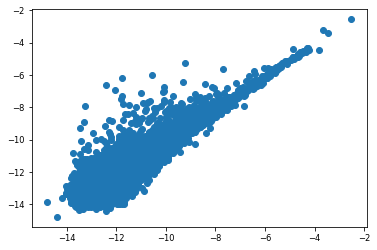

In [188]:
plt.scatter(log_means_1, log_means_2)

In [189]:
def simulate_two_datasets(x_param_1 ,x_param_2, Nc_1, Nc_2, n_cells, q, diff='mean'):
    
    log_means_1, log_variances_1 = np.log(x_param_1[0]), np.log(x_param_1[1])
    log_means_2, log_variances_2 = np.log(x_param_2[0]), np.log(x_param_2[1])
    reg_1 = memento.estimator._fit_mv_regressor(np.exp(log_means_1), np.exp(log_variances_1))
    reg_2 = memento.estimator._fit_mv_regressor(np.exp(log_means_2), np.exp(log_variances_2))
    rv_1 = memento.estimator._residual_variance(np.exp(log_means_1), np.exp(log_variances_1), reg_1)
    rv_2 = memento.estimator._residual_variance(np.exp(log_means_2), np.exp(log_variances_2), reg_2)
    f_1 = np.poly1d(reg_1)
    f_2 = np.poly1d(reg_2)
    
    if diff == 'null':
        norm_cov_1, norm_cov_2 = 'indep', 'indep'
    if diff == 'mean':
        avg_means = (log_means_1+log_means_2)/2
        null_idxs = np.absolute(log_means_1-log_means_2) < 0.25
        log_means_1[null_idxs] = avg_means[null_idxs]
        log_means_2[null_idxs] = avg_means[null_idxs]
        log_variances_1[null_idxs] = f_1(log_means_1[null_idxs])+np.log(rv_1[null_idxs])
        log_variances_2[null_idxs] = f_2(log_means_2[null_idxs])+np.log(rv_2[null_idxs])
        norm_cov_1, norm_cov_2 = 'indep', 'indep'
    if diff == 'variability':
        avg_rvs = np.exp((np.log(rv_1)+np.log(rv_2))/2)
        null_idxs = np.absolute(np.log(rv_1)-np.log(rv_2)) < 0.5
        rv_1[null_idxs] = avg_rvs[null_idxs]
        rv_2[null_idxs] = avg_rvs[null_idxs]
        log_variances_1[null_idxs] = f_1(log_means_1[null_idxs])+np.log(rv_1[null_idxs])
        log_variances_2[null_idxs] = f_2(log_means_2[null_idxs])+np.log(rv_2[null_idxs])
        norm_cov_1, norm_cov_2 = 'indep', 'indep'
    if diff == 'correlation':
        num_dc_genes = 400
        norm_cov_1 = cov2corr(make_spd_matrix(num_dc_genes))
        norm_cov_2 = cov2corr(make_spd_matrix(num_dc_genes))
        es_diff = norm_cov_2 - norm_cov_1
        with open(data_path + 'dc_true_effect_size.pkl', 'wb') as f:
            pkl.dump(es_diff, f)
            
    print((np.exp(log_means_1)*Nc_1.mean() < ((np.exp(log_variances_1) + np.exp(log_means_1)**2)*(Nc_1**2).mean() - np.exp(log_means_1)**2*Nc_1.mean()**2)).mean())
    
    data_1 = simulate.simulate_transcriptomes(
        n_cells=n_cells, 
        means=np.exp(log_means_1)*Nc_1.mean(),
        variances=(np.exp(log_variances_1) + np.exp(log_means_1)**2)*(Nc_1**2).mean() - np.exp(log_means_1)**2*Nc_1.mean()**2,
        Nc=Nc_1,
        norm_cov=norm_cov_1)
    
    data_2 = simulate.simulate_transcriptomes(
        n_cells=n_cells, 
        means=np.exp(log_means_2)*Nc_2.mean(),
        variances=(np.exp(log_variances_2) + np.exp(log_means_2)**2)*(Nc_2**2).mean() - np.exp(log_means_2)**2*Nc_2.mean()**2,
        Nc=Nc_2,
        norm_cov=norm_cov_2)
    
    true_data = np.vstack([data_1, data_2])
    true_data[(true_data < 0) | (true_data > 500)] = 0
    _, hyper_captured = simulate.capture_sampling(true_data, q=q, process='hyper')
    
    print(true_data.sum())
    anndata = sc.AnnData(sp.sparse.csr_matrix(hyper_captured))
    anndata.obs['ct_real'] = ['A' for i in range(n_cells)] + ['B' for i in range(n_cells)]
    anndata.obs['ct_shuffled'] = np.random.choice(['A', 'B'], anndata.shape[0])
    
    if diff != 'correlation':
        anndata.var['is_null'] = null_idxs
        anndata.var['is_sig'] = ~anndata.var['is_null']
    
    if diff == 'correlation':
        return true_data, anndata, None
    else:
        return anndata, None

    


In [190]:
de_sim_adata, de_change_indices = simulate_two_datasets(x_param_1, x_param_2, Nc_1, Nc_2, n_cells=250, q=q, diff='mean')

0.766798418972332


/tmp/ipykernel_25280/3216752186.py:3: RuntimeWarning: invalid value encountered in log
  log_means_1, log_variances_1 = np.log(x_param_1[0]), np.log(x_param_1[1])
/tmp/ipykernel_25280/3216752186.py:4: RuntimeWarning: invalid value encountered in log
  log_means_2, log_variances_2 = np.log(x_param_2[0]), np.log(x_param_2[1])


ValueError: Domain error in arguments.

### Generate simulated binary dataset

In [99]:
ifn_adata = sc.read('/data_volume/memento/demux/' + 'interferon_filtered.h5ad')


In [100]:
adata_1 = ifn_adata[ifn_adata.obs.cell_type == 'CD4 T cells - ctrl']
adata_2 = ifn_adata[ifn_adata.obs.cell_type == 'CD4 T cells - stim']

x_param_1, z_param_1, Nc_1, good_idx_1 = simulate.extract_parameters(adata_1.X, q=q)
x_param_2, z_param_2, Nc_2, good_idx_2 = simulate.extract_parameters(adata_2.X, q=q)

In [101]:
common_set = np.array(list(set(good_idx_1) & set(good_idx_2)))
x_param_1 = (
    np.array([x for x,i in zip(x_param_1[0], good_idx_1) if i in common_set]),
    np.array([x for x,i in zip(x_param_1[1], good_idx_1) if i in common_set]))
x_param_2 = (
    np.array([x for x,i in zip(x_param_2[0], good_idx_2) if i in common_set]),
    np.array([x for x,i in zip(x_param_2[1], good_idx_2) if i in common_set]))

In [102]:
log_means_1, log_variances_1 = np.log(x_param_1[0]), np.log(x_param_1[1])
log_means_2, log_variances_2 = np.log(x_param_2[0]), np.log(x_param_2[1])

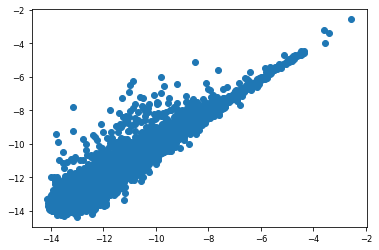

In [103]:
plt.scatter(log_means_1, log_means_2)

In [154]:
def simulate_two_datasets(x_param_1 ,x_param_2, Nc_1, Nc_2, n_cells, q, diff='mean'):
    
    log_means_1, log_variances_1 = np.log(x_param_1[0]), np.log(x_param_1[1])
    log_means_2, log_variances_2 = np.log(x_param_2[0]), np.log(x_param_2[1])
    reg_1 = memento.estimator._fit_mv_regressor(np.exp(log_means_1), np.exp(log_variances_1))
    reg_2 = memento.estimator._fit_mv_regressor(np.exp(log_means_2), np.exp(log_variances_2))
    rv_1 = memento.estimator._residual_variance(np.exp(log_means_1), np.exp(log_variances_1), reg_1)
    rv_2 = memento.estimator._residual_variance(np.exp(log_means_2), np.exp(log_variances_2), reg_2)
    f_1 = np.poly1d(reg_1)
    f_2 = np.poly1d(reg_2)
    
    if diff == 'null':
        norm_cov_1, norm_cov_2 = 'indep', 'indep'
    if diff == 'mean':
        avg_means = (log_means_1+log_means_2)/2
        null_idxs = np.absolute(log_means_1-log_means_2) < 0.25
        log_means_1[null_idxs] = avg_means[null_idxs]
        log_means_2[null_idxs] = avg_means[null_idxs]
        log_variances_1[null_idxs] = f_1(log_means_1[null_idxs])+np.log(rv_1[null_idxs])
        log_variances_2[null_idxs] = f_2(log_means_2[null_idxs])+np.log(rv_2[null_idxs])
        norm_cov_1, norm_cov_2 = 'indep', 'indep'
    if diff == 'variability':
        avg_rvs = np.exp((np.log(rv_1)+np.log(rv_2))/2)
        null_idxs = np.absolute(np.log(rv_1)-np.log(rv_2)) < 0.5
        rv_1[null_idxs] = avg_rvs[null_idxs]
        rv_2[null_idxs] = avg_rvs[null_idxs]
        log_variances_1[null_idxs] = f_1(log_means_1[null_idxs])+np.log(rv_1[null_idxs])
        log_variances_2[null_idxs] = f_2(log_means_2[null_idxs])+np.log(rv_2[null_idxs])
        norm_cov_1, norm_cov_2 = 'indep', 'indep'
    if diff == 'correlation':
        num_dc_genes = 400
        norm_cov_1 = cov2corr(make_spd_matrix(num_dc_genes))
        norm_cov_2 = cov2corr(make_spd_matrix(num_dc_genes))
        es_diff = norm_cov_2 - norm_cov_1
        with open(data_path + 'dc_true_effect_size.pkl', 'wb') as f:
            pkl.dump(es_diff, f)
            
    print((np.exp(log_means_1)*Nc_1.mean() < ((np.exp(log_variances_1) + np.exp(log_means_1)**2)*(Nc_1**2).mean() - np.exp(log_means_1)**2*Nc_1.mean()**2)).mean())
    
    data_1 = simulate.simulate_transcriptomes(
        n_cells=n_cells, 
        means=np.exp(log_means_1)*Nc_1.mean(),
        variances=(np.exp(log_variances_1) + np.exp(log_means_1)**2)*(Nc_1**2).mean() - np.exp(log_means_1)**2*Nc_1.mean()**2,
        Nc=Nc_1,
        norm_cov=norm_cov_1)
    
    data_2 = simulate.simulate_transcriptomes(
        n_cells=n_cells, 
        means=np.exp(log_means_2)*Nc_2.mean(),
        variances=(np.exp(log_variances_2) + np.exp(log_means_2)**2)*(Nc_2**2).mean() - np.exp(log_means_2)**2*Nc_2.mean()**2,
        Nc=Nc_2,
        norm_cov=norm_cov_2)
    
    true_data = np.vstack([data_1, data_2])
    true_data[(true_data < 0) | (true_data > 500)] = 0
    _, hyper_captured = simulate.capture_sampling(true_data, q=q, process='hyper')
    
    print(true_data.sum())
    anndata = sc.AnnData(sp.sparse.csr_matrix(hyper_captured))
    anndata.obs['ct_real'] = ['A' for i in range(n_cells)] + ['B' for i in range(n_cells)]
    anndata.obs['ct_shuffled'] = np.random.choice(['A', 'B'], anndata.shape[0])
    
    if diff != 'correlation':
        anndata.var['is_null'] = null_idxs
        anndata.var['is_sig'] = ~anndata.var['is_null']
    
    if diff == 'correlation':
        return true_data, anndata, None
    else:
        return anndata, None

    


In [155]:
Nc_1

array([10042.857, 26700.   , 11671.429, ..., 25857.143, 14000.   ,
       20157.143], dtype=float32)

In [156]:
de_sim_adata, de_change_indices = simulate_two_datasets(x_param_1, x_param_2, Nc_1, Nc_2, n_cells=250, q=q, diff='mean')

0.9708357799960854
7405136


/tmp/ipykernel_25280/3216752186.py:59: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata = sc.AnnData(sp.sparse.csr_matrix(hyper_captured))


### Simulate cells for DE

In [38]:
# %%time
# de_sim_adata, de_change_indices = simulate_two_datasets(x_param_1, x_param_2, Nc_1, Nc_2, n_cells=250, q=q, diff='mean')
# de_sim_adata.write(data_path + 'de.h5ad')

### Simulate cells for DV

In [39]:
# dv_sim_adata, dv_change_indices = simulate_two_datasets(x_param_1, x_param_2, Nc_1, Nc_2, n_cells=1000, q=q, diff='variability')
# dv_sim_adata.write(data_path + 'dv.h5ad')

### Simulate cells for DC

In [40]:
true_data, dc_sim_adata, null_idxs = simulate_two_datasets(x_param_1, x_param_2, Nc_1, Nc_2, n_cells=1000, q=q, diff='correlation')
dc_sim_adata.write(data_path + 'dc.h5ad')

... storing 'ct_real' as categorical
... storing 'ct_shuffled' as categorical


### Try to simulate

In [153]:
def convert_params_nb(mu, theta):
	"""
	Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

	See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
	"""
	r = theta
	var = mu + 1 / r * mu ** 2
	p = (var - mu) / var
	return r, 1 - p

In [332]:
##### m = (np.exp(log_means_1)*Nc_1.mean())[:50]
v = ((np.exp(log_variances_1) + np.exp(log_means_1)**2)*(Nc_1**2).mean() - np.exp(log_means_1)**2*Nc_1.mean()**2)[:50]

d = (v - m)/m**2
d[d < 0] = 1e-5
t = 1/d

num_dc_genes = 50
norm_cov = make_spd_matrix(50)
norm_cov = cov2corr(norm_cov)
# norm_cov = np.eye(50)
# norm_cov2 = cov2corr(make_spd_matrix(50))
# norm_cov_avg = (norm_cov + norm_cov2)/2

# np.fill_diagonal(norm_cov, 1)
# norm_cov[:3, :3] = -0.8
# norm_cov = np.random.random((num_dc_genes, num_dc_genes))


<AxesSubplot:ylabel='Density'>

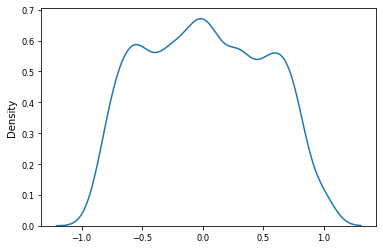

In [334]:
sns.kdeplot(norm_cov.ravel())

In [324]:
import numpy as np

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) >= 0)

In [325]:
gaussian_variables = stats.multivariate_normal.rvs(mean=np.zeros(50), cov=norm_cov, size=1000)
uniform_variables = stats.norm.cdf(gaussian_variables)
nbinom_variables = stats.nbinom.ppf(uniform_variables, *convert_params_nb(m, t))




In [326]:
stats.pearsonr(nbinom_variables[:, 0], nbinom_variables[:, 1])

(0.051742522620752705, 0.10198800955309255)

<AxesSubplot:ylabel='Density'>

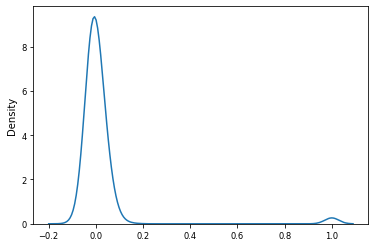

In [327]:
sns.kdeplot(np.corrcoef(nbinom_variables, rowvar=False).ravel())


<AxesSubplot:ylabel='Density'>

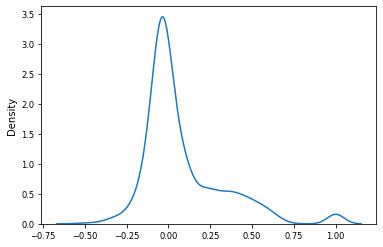

In [322]:
sns.kdeplot(np.corrcoef(nbinom_variables, rowvar=False).ravel())


In [261]:
num_dc_genes = 50
norm_cov_1 = np.ones((num_dc_genes, num_dc_genes))*0
np.fill_diagonal(norm_cov_1, 1)

In [34]:
a = np.corrcoef(dc_sim_adata[:1000, :].X.toarray(), rowvar=False)
b = np.corrcoef(dc_sim_adata[1000:, :].X.toarray(), rowvar=False)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [35]:
diff = a-b

<AxesSubplot:ylabel='Density'>

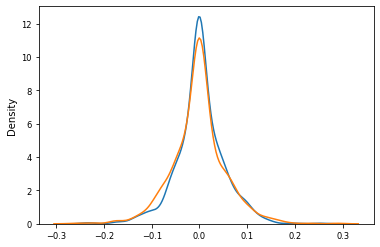

In [36]:
sns.kdeplot(np.random.choice(diff[null_idxs], 1000))
sns.kdeplot(np.random.choice(diff[~null_idxs], 1000))

### Power calculation (maybe)

In [ ]:
def calculate_power(n_cells, test='mean', test_null=False):
    
    sim_adata, change_indices = simulate_two_datasets(x_param, Nc, n_cells, q=q, diff=test if not test_null else 'null')
        
    schypo.create_groups(
        sim_adata,
        q=q,
        label_columns=['ct_real'], 
        inplace=True)
    
    schypo.compute_1d_moments(
        sim_adata, 
        inplace=True, 
        filter_genes=False, 
        residual_var=True,
        filter_mean_thresh=0.0, 
        min_perc_group=.9)
        
    if test == 'mean':

        schypo.ht_1d_moments(
            sim_adata, 
            formula_like='1 + ct_real',
            cov_column='ct_real',
            num_boot=5000,
            num_cpus=6,
            verbose=3)

        power = (sim_adata.uns['schypo']['1d_ht']['mean_asl'][:500] < 0.05).mean()
        pvals = sim_adata.uns['schypo']['1d_ht']['mean_asl']
        
    if test == 'variability':

        schypo.ht_1d_moments(
            sim_adata, 
            formula_like='1 + ct_real',
            cov_column='ct_real',
            num_boot=5000,
            num_cpus=6,
            verbose=3)
        
        power = (sim_adata.uns['schypo']['1d_ht']['var_asl'][:500] < 0.05).mean()
        pvals = sim_adata.uns['schypo']['1d_ht']['var_asl']
        
    if test == 'correlation':
        
        schypo.compute_2d_moments(
            sim_adata, 
            inplace=True, 
            gene_1=np.arange(50).astype(str).tolist(),
            gene_2=np.arange(50).astype(str).tolist())
        
        schypo.ht_2d_moments(
            sim_adata, 
            formula_like='1 + ct_real',
            cov_column='ct_real',
            num_boot=5000,
            num_cpus=6,
            verbose=3)
        
        c_pv = sim_adata.uns['schypo']['2d_ht']['corr_asl'][:50, :50]
        power = (c_pv[change_indices] < 0.05).mean()
        pvals = sim_adata.uns['schypo']['2d_ht']['corr_asl']
                
    return power, pvals, sim_adata

In [ ]:
mean_power, var_power, corr_power = [], [], []
n_cells_list = np.logspace(2, 5, 25).astype(int)
for n_cells in n_cells_list:
    
    print(n_cells)
    
    mean_power.append(calculate_power(n_cells, test='mean')[0])
    var_power.append(calculate_power(n_cells, test='variability')[0])
    corr_power.append(calculate_power(n_cells, test='correlation')[0])

with open('temp.pkl', 'wb') as f:
    pkl.dump([mean_power, var_power, corr_power], f)

In [242]:
n_cells_list = np.logspace(2, 5, 25).astype(int)

with open('/data/parameter_estimation/simulation/power_analysis.pkl', 'rb') as f:
    mean_power, var_power, corr_power = pkl.load(f)

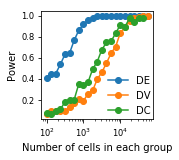

In [252]:
plt.figure(figsize=(2, 2))
plt.plot(n_cells_list[:23], mean_power, '-o')
plt.plot(n_cells_list[:23], var_power, '-o')
plt.plot(n_cells_list[:22], corr_power, '-o')
plt.xscale('log')
plt.xlabel('Number of cells in each group')
plt.ylabel('Power')
plt.legend(['DE', 'DV', 'DC'], loc='lower right', bbox_to_anchor=(0.56, -0.05, 0.5, 0.5), frameon=False)
plt.savefig(fig_path + 'power.pdf', bbox_inches='tight')

In [76]:
# with open('temp.pkl', 'wb') as f:
#     pkl.dump([mean_power, var_power, corr_power], f)

### Generate p-value histograms

In [198]:
adata = ifn_adata[ifn_adata.obs.cell_type == 'CD4 T cells - ctrl']
# data = adata.X.copy()
# relative_data = data.toarray()/data.sum(axis=1)

n_cells = 5000
q=0.07
x_param, z_param, Nc, good_idx = simulate.extract_parameters(adata.X, q=q, min_mean=0.001)

In [199]:
sim_adata_mean, _ = simulate_two_datasets(x_param, Nc, n_cells, q=q, diff='mean')

In [200]:
print(sim_adata_mean.shape)

schypo.create_groups(
    sim_adata_mean,
    q=q,
    label_columns=['ct_real'], 
    inplace=True)
schypo.compute_1d_moments(
    sim_adata_mean, 
    inplace=True, 
    filter_genes=True, 
    residual_var=True,
    filter_mean_thresh=0.00001, 
    min_perc_group=.9)
schypo.ht_1d_moments(
	sim_adata_mean, 
	formula_like='1 + ct_real',
	cov_column='ct_real',
	num_boot=5000,
    num_cpus=6,
    verbose=3)

(10000, 10805)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    2.1s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:   10.1s
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:   17.5s
[Parallel(n_jobs=6)]: Done 1030 tasks      | elapsed:   26.0s
[Parallel(n_jobs=6)]: Done 1734 tasks      | elapsed:   37.1s
[Parallel(n_jobs=6)]: Done 2566 tasks      | elapsed:   50.3s
[Parallel(n_jobs=6)]: Done 3526 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 4614 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 5830 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 7174 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 8646 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 10246 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 10798 out of 10798 | elapsed:  3.0min finished


In [201]:
sim_adata_mean.write('/data/parameter_estimation/simulation/sim_mean.h5ad')

... storing 'ct_real' as categorical
... storing 'ct_shuffled' as categorical
... storing 'schypo_group' as categorical


In [147]:
sim_adata_var, _ = simulate_two_datasets(x_param, Nc, n_cells, q=q, diff='variability')

schypo.create_groups(
    sim_adata_var,
    q=q,
    label_columns=['ct_real'], 
    inplace=True)
schypo.compute_1d_moments(
    sim_adata_var, 
    inplace=True, 
    filter_genes=True, 
    residual_var=True,
    filter_mean_thresh=0.05, 
    min_perc_group=.9)
schypo.ht_1d_moments(
	sim_adata_var, 
	formula_like='1 + ct_real',
	cov_column='ct_real',
	num_boot=5000,
    num_cpus=6,
    verbose=3)

(10000, 10800)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  28 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 220 tasks      | elapsed:    6.9s
[Parallel(n_jobs=6)]: Done 540 tasks      | elapsed:   15.8s
[Parallel(n_jobs=6)]: Done 988 tasks      | elapsed:   28.4s
[Parallel(n_jobs=6)]: Done 1564 tasks      | elapsed:   45.8s
[Parallel(n_jobs=6)]: Done 2268 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2364 out of 2375 | elapsed:  1.1min remaining:    0.3s
[Parallel(n_jobs=6)]: Done 2375 out of 2375 | elapsed:  1.2min finished


In [158]:
sim_adata_var.write('/data/parameter_estimation/simulation/sim_var.h5ad')

... storing 'ct_real' as categorical
... storing 'ct_shuffled' as categorical
... storing 'schypo_group' as categorical


In [225]:
x_param, z_param, Nc, good_idx = simulate.extract_parameters(adata.X, q=q, min_mean=0.05)
sim_adata_corr, change_indices = simulate_two_datasets(x_param, Nc, n_cells, q=q, diff='correlation')


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/scipy/stats/_multivariate.py:660: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


In [226]:
schypo.create_groups(
    sim_adata_corr,
    q=q,
    label_columns=['ct_real'], 
    inplace=True)
schypo.compute_1d_moments(
    sim_adata_corr, 
    inplace=True, 
    filter_genes=True, 
    residual_var=True,
    filter_mean_thresh=0.0, 
    min_perc_group=.9)
schypo.compute_2d_moments(
    sim_adata_corr, 
    inplace=True, 
    gene_1=np.arange(100).astype(str).tolist(),
    gene_2=np.arange(100).astype(str).tolist())
schypo.ht_2d_moments(
    sim_adata_corr, 
    formula_like='1 + ct_real',
    cov_column='ct_real',
    num_boot=5000,
    num_cpus=6,
    verbose=3)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    2.5s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    7.6s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:   16.4s
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:   27.1s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:   42.1s
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 2036 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 2580 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 3860 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 4596 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 4950 out of 4950 | elapsed:  4.8min finished


In [227]:
sim_adata_corr.uns['null'] = corr_asl_null

In [228]:
sim_adata_corr.write('/data/parameter_estimation/simulation/sim_corr.h5ad')

... storing 'ct_real' as categorical
... storing 'ct_shuffled' as categorical
... storing 'schypo_group' as categorical


### Plot p-value histograms

In [194]:
sim_adata_var = sc.read('/data/parameter_estimation/simulation/sim_var.h5ad')
var_asl = sim_adata_var.uns['schypo']['1d_ht']['var_asl']

In [202]:
sim_adata_mean = sc.read('/data/parameter_estimation/simulation/sim_mean.h5ad')
mean_asl = sim_adata_mean.uns['schypo']['1d_ht']['mean_asl']

In [231]:
sim_adata_corr = sc.read('/data/parameter_estimation/simulation/sim_corr.h5ad')
corr_asl = sim_adata_corr.uns['schypo']['2d_ht']['corr_asl'].ravel()
corr_null_asl = sim_adata_corr.uns['null'].ravel()

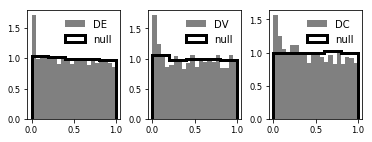

In [253]:
plt.figure(figsize=(6, 2));
plt.subplots_adjust(wspace=0.3)

plt.subplot(1, 3, 1);
plt.hist(mean_asl, bins=20, density=True, color='grey', label='DE');
plt.hist(mean_asl[500:], bins=5, density=True, histtype='step', linewidth=3, color='black', label='null');
plt.legend(frameon=False)

plt.subplot(1, 3, 2);
plt.hist(var_asl, bins=20, density=True, color='grey', label='DV');
plt.hist(var_asl[500:], bins=5, density=True, histtype='step', linewidth=3, color='black', label='null');
plt.legend(frameon=False)

plt.subplot(1, 3, 3);
plt.hist(corr_asl.ravel(), density=True, color='grey', bins=20, label='DC');
plt.hist(corr_asl_null.ravel(), bins=5, density=True, color='black', label='null', histtype='step', linewidth=3);
plt.legend(frameon=False)
plt.savefig(fig_path + 'calibration_histograms.pdf', bbox_inches='tight')